In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
data_path = 'ml-10M100K/ratings.dat'
n_users = 71567
n_movies = 10681

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [3]:
def load_rating_data(data_path,n_users,n_movies):
    data = np.zeros([n_users,n_movies],dtype=np.float32)
    movie_id_mapping = {}
    movie_n_rating = defaultdict(int)
    with open(data_path,'r') as file:
        for line in file.readlines()[1:]:
            user_id,movie_id,rating,_ = line.split("::")
            user_id = int(user_id) - 1
            if movie_id not in movie_id_mapping:
                movie_id_mapping[movie_id] = len(movie_id_mapping)
            rating = int(float(rating))
            
            data[user_id,movie_id_mapping[movie_id]] = rating
            
            if rating>0:
                movie_n_rating[movie_id] += 1
                
    return data,movie_n_rating,movie_id_mapping

In [4]:
data,movie_n_rating,movie_id_mapping = load_rating_data(data_path,n_users,n_movies)

In [5]:
def display_distribution(data):
    values,counts = np.unique(data,return_counts=True)
    for value,count in zip(values,counts):
        print(f'Number of rating {int(value)}: {count}')

In [6]:
display_distribution(data)

Number of rating 0: 754502062
Number of rating 1: 502458
Number of rating 2: 1160484
Number of rating 3: 3236440
Number of rating 4: 3460872
Number of rating 5: 1544811


In [7]:
movie_id_most,n_rating_most = sorted(movie_n_rating.items(),key=lambda d:d[1],reverse=True)[0]
print(f'Movie ID {movie_id_most} has {n_rating_most} ratings.')

Movie ID 296 has 34756 ratings.


In [8]:
# Since most rating are unknown, we take the movie with the most rating as our target movie.

In [9]:
X_raw = np.delete(data,movie_id_mapping[movie_id_most],axis=1)
Y_raw = data[:,movie_id_mapping[movie_id_most]]

In [10]:
print(X_raw.shape,Y_raw.shape)

(71567, 10680) (71567,)


In [11]:
X = X_raw[Y_raw > 0]
Y = Y_raw[Y_raw > 0]
print('Shape of X: ',X.shape)
print('Shape of Y: ',Y.shape)

Shape of X:  (34756, 10680)
Shape of Y:  (34756,)


In [12]:
display_distribution(Y)

Number of rating 1: 1030
Number of rating 2: 1388
Number of rating 3: 5476
Number of rating 4: 11889
Number of rating 5: 14973


In [13]:
recommend = 3
Y[Y <= recommend] = 0
Y[Y > recommend] = 1
n_pos = (Y==1).sum()
n_neg = (Y==0).sum()
print(f'{n_pos} positive samples and {n_neg} negative samples.')

26862 positive samples and 7894 negative samples.


In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2,random_state=42)

In [15]:
print(len(Y_train),len(Y_test))

27804 6952


In [16]:
clf = MultinomialNB(alpha=1.0,fit_prior=True)
clf.fit(X_train,Y_train)

MultinomialNB()

In [17]:
prediction_prob = clf.predict_proba(X_test)
print(prediction_prob[:10])

[[1.42206797e-12 1.00000000e+00]
 [1.33502332e-31 1.00000000e+00]
 [9.99223787e-01 7.76213294e-04]
 [1.08495315e-16 1.00000000e+00]
 [6.17403325e-05 9.99938260e-01]
 [9.99999961e-01 3.85937752e-08]
 [1.42256921e-42 1.00000000e+00]
 [1.46517456e-17 1.00000000e+00]
 [1.61249328e-22 1.00000000e+00]
 [4.41258271e-95 1.00000000e+00]]


In [18]:
prediction = clf.predict(X_test)
print(prediction[:10])

[1. 1. 0. 1. 1. 0. 1. 1. 1. 1.]


In [19]:
accuracy = clf.score(X_test,Y_test)
print(f'The accuracy is : {accuracy*100:.1f}%')

The accuracy is : 60.1%


In [20]:
from sklearn.metrics import confusion_matrix

In [21]:
print(confusion_matrix(Y_test,prediction,labels=[0,1]))

[[ 983  521]
 [2256 3192]]


In [22]:
from sklearn.metrics import precision_score,recall_score,f1_score
precision_score(Y_test,prediction,pos_label=1)

0.8596821976838136

In [23]:
recall_score(Y_test,prediction,pos_label=1)

0.5859030837004405

In [24]:
f1_score(Y_test,prediction,pos_label=1)

0.6968671542408035

In [25]:
from sklearn.metrics import classification_report
report = classification_report(Y_test,prediction)
print(report)

              precision    recall  f1-score   support

         0.0       0.30      0.65      0.41      1504
         1.0       0.86      0.59      0.70      5448

    accuracy                           0.60      6952
   macro avg       0.58      0.62      0.56      6952
weighted avg       0.74      0.60      0.64      6952



In [26]:
pos_prob = prediction_prob[:,1]
thresholds = np.arange(0.0,1.1,0.05)
true_pos,false_pos = [0]*len(thresholds),[0]*len(thresholds)

for pred,y in zip(pos_prob,Y_test):
    for i,threshold in enumerate(thresholds):
        if pred >= threshold:
            if y == 1:
                true_pos[i] += 1
            else:
                false_pos[i] += 1
        else:
            break

In [28]:
n_pos_test = (Y_test == 1).sum()
n_neg_test = (Y_test == 0).sum()
print(f'+ {n_pos_test} - {n_neg_test}')

+ 5448 - 1504


In [30]:
true_pos_rate = [tp/ n_pos_test for tp in true_pos]
false_pos_rate = [fp/n_neg_test for fp in false_pos]

In [29]:
import matplotlib.pyplot as plt

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


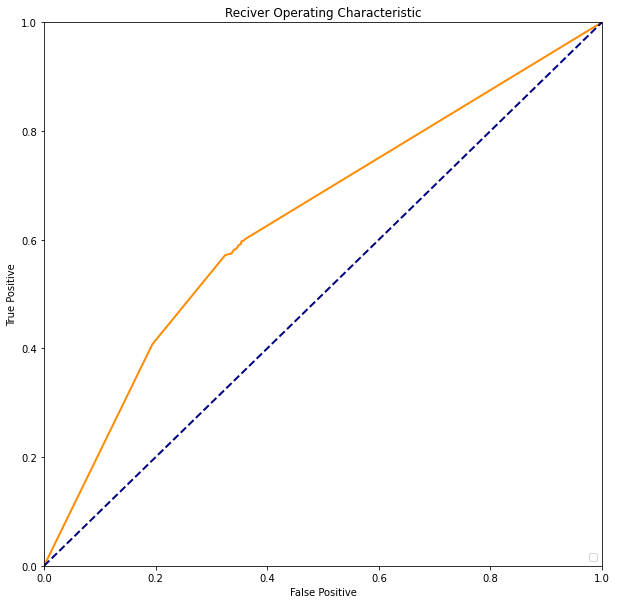

In [34]:
plt.figure(figsize=(10,10))
lw = 2
plt.plot(false_pos_rate,true_pos_rate,color='darkorange',lw=lw)
plt.plot([0,1],[0,1],color='navy',lw=lw,linestyle = '--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title("Reciver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

In [35]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Y_test,pos_prob)

0.6557523671579655

In [37]:
from sklearn.model_selection import StratifiedKFold
k=5
k_fold = StratifiedKFold(n_splits=k)

In [38]:
smoothing_factor_option = [1,2,3,4,5,6]
fit_prior_option = [True,False]
auc_record = {}

In [40]:
for train_indices,test_indices in k_fold.split(X,Y):
    X_train,X_test = X[train_indices],X[test_indices]
    Y_train,Y_test = Y[train_indices],Y[test_indices]
    for alpha in smoothing_factor_option:
        if alpha not in auc_record:
            auc_record[alpha] = {}
        for fit_prior in fit_prior_option:
            clf = MultinomialNB(alpha=alpha,fit_prior=fit_prior)
            clf.fit(X_train,Y_train)
            prediction_prob = clf.predict_proba(X_test)
            pos_prob = prediction_prob[:,1]
            auc = roc_auc_score(Y_test,pos_prob)
            auc_record[alpha][fit_prior] = auc + auc_record[alpha].get(fit_prior,0.0)

In [41]:
for smoothing,smoothing_record in auc_record.items():
    for fit_prior,auc in smoothing_record.items():
        print(f'   {smoothing}    {fit_prior}    {auc/k:.5f}')

   1    True    0.66323
   1    False    0.66346
   2    True    0.66333
   2    False    0.66370
   3    True    0.66350
   3    False    0.66379
   4    True    0.66362
   4    False    0.66402
   5    True    0.66367
   5    False    0.66417
   6    True    0.66369
   6    False    0.66388


In [42]:
(5,False)

(5, False)

In [43]:
clf = MultinomialNB(alpha=5,fit_prior=False)
clf.fit(X_train,Y_train)
pos_prob = clf.predict_proba(X_test)[:,1]
print('AUC with the best model : ',roc_auc_score(Y_test,pos_prob))

AUC with the best model :  0.6747779761597265


### :)